In [8]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/data_packetbeat.csv', low_memory=False)
df = df.dropna(axis=1, how ='all')
df = df[['source.bytes', 'source.packets','destination.bytes', 'destination.packets', 'network.packets', 'network.bytes', 'network.transport', 'event.duration']]
df = df.dropna()
df = df.reset_index()
del df['index']
df

,source.bytes,source.packets,destination.bytes,destination.packets,network.packets,network.bytes,network.transport,event.duration
0,"23,080",335.0,"307,728",327.0,662,"330,808",tcp,"9,149,952,108,596"
1,112,2.0,56,1.0,3,168,tcp,"87,498"
2,"1,848",15.0,"2,289",10.0,25,"4,137",tcp,"5,632,239,245"
3,"1,792",14.0,"2,289",10.0,24,"4,081",tcp,"3,583,794,677"
4,"1,848",15.0,"2,289",10.0,25,"4,137",tcp,"4,096,117,409"
...,...,...,...,...,...,...,...,...
11324,90,1.0,178,1.0,2,268,udp,"92,675"
11325,90,1.0,178,1.0,2,268,udp,"103,432"
11326,92,1.0,92,1.0,2,184,udp,"49,203"
11327,90,1.0,178,1.0,2,268,udp,"92,502"


In [2]:
'''
from sklearn import preprocessing

df['event.duration'] = df['event.duration'].str.replace(',', '')

for var in ['source.bytes', 'destination.bytes', 'network.bytes', 'network.packets']:
    df[var] = df[var].str.replace(',', '').astype(float)    

df
'''

"\nfrom sklearn import preprocessing\n\ndf['event.duration'] = df['event.duration'].str.replace(',', '')\n\nfor var in ['source.bytes', 'destination.bytes', 'network.bytes', 'network.packets']:\n    df[var] = df[var].str.replace(',', '').astype(float)    \n\ndf\n"

In [9]:
from sklearn import preprocessing

df = df.drop(['network.transport'], axis=1)

for col in df.columns.values:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)
    
df

AttributeError: Can only use .str accessor with string values!

In [4]:
from sklearn.preprocessing import StandardScaler

# Standardizing data is recommended because otherwise the range of values in each feature will act as a weight when determining how to cluster data, which is typically undesired.
#df_dbscan = df.drop(['network.transport'], axis=1)
df_dbscan = df
df_scalled = StandardScaler().fit_transform(df_dbscan)

df_scalled = pd.DataFrame(df_scalled, columns=df_dbscan.columns.values)
df_scalled

,source.bytes,source.packets,destination.bytes,destination.packets,network.packets,network.bytes,event.duration
0,-0.199527,-0.193716,-0.205353,-0.205223,-0.199052,-0.199968,-0.209009
1,-0.257850,-0.267667,-0.254513,-0.253043,-0.261209,-0.257606,-0.250465
2,-0.259757,-0.267991,-0.255148,-0.253435,-0.261565,-0.259418,-0.252071
3,-0.259819,-0.268640,-0.255761,-0.254219,-0.262275,-0.259521,-0.252372
4,-0.259796,-0.268315,-0.255761,-0.254219,-0.262097,-0.259500,-0.252372
...,...,...,...,...,...,...,...
12118,-0.258719,-0.268315,-0.255291,-0.253827,-0.261920,-0.258468,-0.252372
12119,-0.259672,-0.266694,-0.255411,-0.253827,-0.261032,-0.259359,-0.252372
12120,-0.259746,-0.267667,-0.255411,-0.253827,-0.261565,-0.259428,-0.252372
12121,-0.259796,-0.268315,-0.255455,-0.253827,-0.261920,-0.259477,-0.252372


## DBSCAN
https://towardsdatascience.com/best-clustering-algorithms-for-anomaly-detection-d5b7412537c8

https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80

There are two key parameters in this models:

    - eps: Maximum distance between two points to consider them as neighbors. If this distance is too large we might end up with all the points in one huge cluster, however, if it’s too small we might not even form a cluster.
    - min_points: Minimum number of points to form a cluster. If we set a low value for this parameters we might end up with a lot of really small clusters, however, a large value can stop the algorithm for creating any cluster, ending up with a dataset form only by anomalies.

Advantages of DBSCAN:

    - DBSCAN algorithm is robust to outliers (noise points).
    - DBSCAN is great at separating high density clusters from low density clusters.
    - Unlike K-means, DBSCAN does not require number of clusters to be specified priorily.
    - DBSCAN supports non-globular structures as well.

Disadvantages of DBSCAN:

    - DBSCAN does not work well for clusters of varying density. Although it clusters high density regions separating them from low density points, it struggles a lot in case of clusters of similar density.
    - DBSCAN algorithm is not deterministic in the sense that it forms different clusters on different trials. The reason is that the border point that is reachable from more than one core point can join either cluster, depending on the order of processing the data points.
    - Sometimes, choosing the value of ‘epsilon’ can be difficult especially when the data is in higher dimensions.

In [5]:
from sklearn.cluster import DBSCAN

db_model = DBSCAN(eps=0.3, min_samples=10).fit(df_scalled)
core_samples_mask = np.zeros_like(db_model.labels_, dtype=bool)
core_samples_mask[db_model.core_sample_indices_] = True
labels = db_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 2
Estimated number of noise points: 0


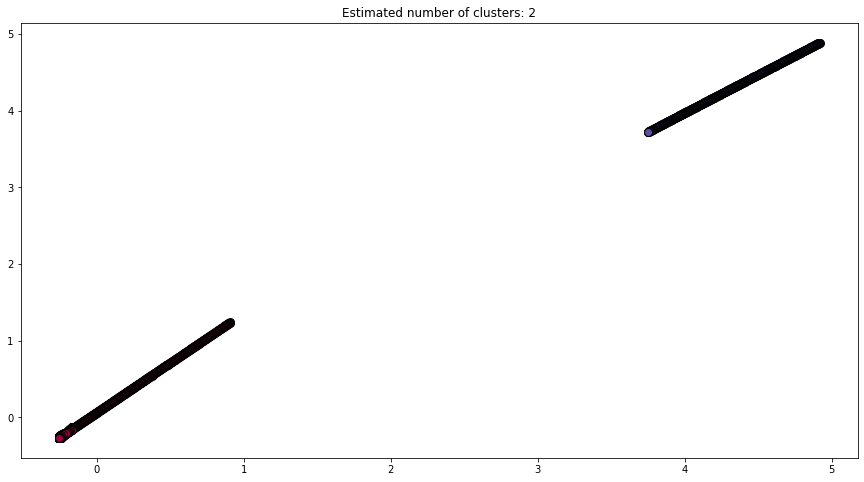

In [7]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(15,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_scalled[class_member_mask & core_samples_mask]
   
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=8)

    xy = df_scalled[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=4)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [6]:
import collections

collections.Counter(db_model.labels_)

Counter({0: 482, 1: 10665, 2: 10, -1: 154, 3: 18})

## HDBSCAN

https://github.com/scikit-learn-contrib/hdbscan

In [9]:
import hdbscan

ModuleNotFoundError: No module named 'hdbscan'

## OPTICS

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html

In [7]:
from sklearn.cluster import OPTICS

opt_model = OPTICS(min_samples=10).fit(df_scalled)
#core_samples_mask = np.zeros_like(opt_model.labels_, dtype=bool)
#core_samples_mask[opt_model.core_sample_indices_] = True
labels = opt_model.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 546
Estimated number of noise points: 1926


Z:\Programacion\Miniconda\envs\AI\lib\site-packages\sklearn\cluster\_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


## GMM